In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
xtrain = np.load('data/xtrain.npy')
ytrain = np.load('data/ytrain.npy')
xtest = np.load('data/xtest.npy')

In [3]:
xtrain.shape, ytrain.shape, xtest.shape

((15137, 256, 256, 1), (15137, 8), (5, 256, 256, 1))

In [4]:
def view_image(img, mark):
    img = img.reshape((256, 256))
    mark = 256*mark.reshape((4, 2))
    plt.imshow(img, cmap='gray')
    plt.plot(mark[0][0], mark[0][1], 'bo')
    plt.plot(mark[1][0], mark[1][1], 'bo')
    plt.plot(mark[2][0], mark[2][1], 'bo')
    plt.plot(mark[3][0], mark[3][1], 'bo')
    plt.show()

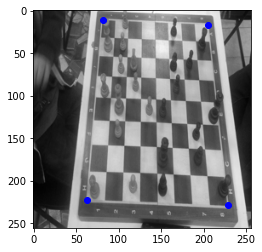

In [5]:
view_image(xtrain[1], ytrain[1])

In [6]:
def define_box(data):
    pos = 1
    xmin = data[0]
    xmax = data[4]
    ymin = data[1]
    ymax = data[5]
    return [pos, xmin, xmax, ymin, ymax]

In [7]:
class ChessDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transforms = None):
        self.data = torch.as_tensor(data, dtype=torch.float32)
        self.keypoints = torch.as_tensor(target, dtype=torch.float32)
        self.transforms = transforms
    def __getitem__(self, idx):
        image = self.data[idx].reshape((1, 256, 256, 1))
        keypoint = self.keypoints[idx]
        if self.transforms is not None:
            data = self.transforms({'images': self.data[idx],'keypoints': self.keypoints[idx]})
            image = data['images']
            keypoints = data['keypoints']
        return {'images': image, 'keypoints': keypoints}
    def __len__(self):
        return len(self.data)

In [8]:
dataset = ChessDataset(xtrain, ytrain)

In [9]:
class Normalize(object):
    def __call__(self, data):
        return {'images': data['images']/255., 'keypoints': data['keypoints']}

In [10]:
class Reshape(object):
    def __call__(self, data):
        return {'images': data['images'].reshape((1, 256, 256)), 'keypoints': data['keypoints']}

In [11]:
class ToTensor(object):
    def __call__(self, data):
        image = data['images'].reshape(1, 256, 256, 1)
        print(type(image))
        image = torch.from_numpy(image)
        keypoints = torch.from_numpy(keypoints)
        return {'images': image, 'keypoints': keypoints}

In [12]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, batch_size=128):
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [13]:
from torchvision import transforms

# how many samples per batch to load
batch_size = 1
# percentage of training set to use as validation
valid_size = 0.2

# Define a transform to normalize the data
tsfm = transforms.Compose([Normalize(), Reshape()])

# Load the training data and test data
trainset = ChessDataset(xtrain[:1000], ytrain[:1000], transforms=tsfm)

# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset, valid_size, batch_size)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, outputs=8):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(65536, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.6)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x


class MoreDeepCNN(nn.Module):
    def __init__(self, outputs=8):
        super(MoreDeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = torch.flatten(x)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x

class AdvancedCNN(nn.Module):
    def __init__(self, outputs=8):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv7 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv8 = nn.Conv2d(16, 16, 3, padding=1)
        self.fc1 = nn.Linear(16384, 256)
        self.fc2 = nn.Linear(256, 8)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.pool(F.relu(self.conv8(x)))
        x = torch.flatten(x)
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(x))
        return x

In [15]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        print('epoch: ', epoch)
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        it = 0
        for batch in train_loader:
            it = it + 1
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['images'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['images'].size(0)
            if it % 200 == 0:
                print('iteration: ', it, ' loss:', train_loss)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['images'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['images'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        plt.plot(valid_losses)
        plt.show()
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses 

cuda
----train-----
epoch:  0


/storage/NeklyudovS/banzai/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([1, 8])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


iteration:  200  loss: 23.103414826095104
iteration:  400  loss: 45.899938359856606
iteration:  600  loss: 68.508022621274
iteration:  800  loss: 91.13310092687607


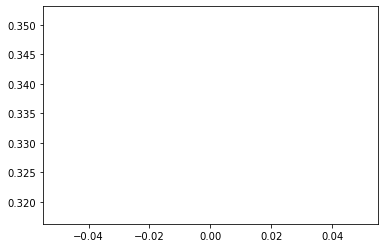

Epoch: 1 	Training Loss: 0.337515 	Validation Loss: 0.334700
Validation loss decreased (inf --> 0.334700).  Saving model ...
epoch:  1
iteration:  200  loss: 22.283896766602993
iteration:  400  loss: 44.912151485681534
iteration:  600  loss: 67.39817614853382
iteration:  800  loss: 90.17925091832876


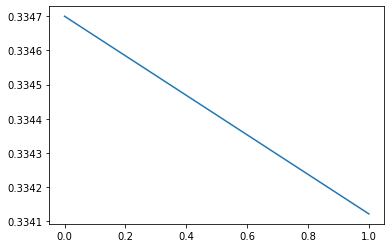

Epoch: 2 	Training Loss: 0.335744 	Validation Loss: 0.334122
Validation loss decreased (0.334700 --> 0.334122).  Saving model ...
epoch:  2
iteration:  200  loss: 22.240302368998528
iteration:  400  loss: 45.17930845171213
iteration:  600  loss: 67.51056352257729
iteration:  800  loss: 90.01550463587046


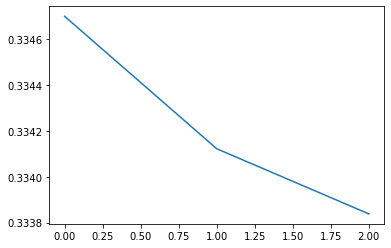

Epoch: 3 	Training Loss: 0.335439 	Validation Loss: 0.333838
Validation loss decreased (0.334122 --> 0.333838).  Saving model ...
epoch:  3
iteration:  200  loss: 22.498512126505375
iteration:  400  loss: 44.85079938173294
iteration:  600  loss: 67.28159853816032
iteration:  800  loss: 89.93005565553904


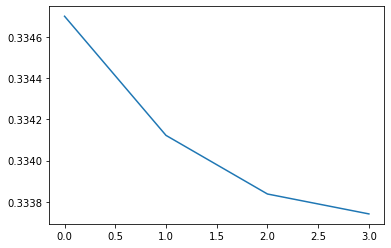

Epoch: 4 	Training Loss: 0.335280 	Validation Loss: 0.333741
Validation loss decreased (0.333838 --> 0.333741).  Saving model ...
epoch:  4
iteration:  200  loss: 22.44020462781191
iteration:  400  loss: 44.96898117661476
iteration:  600  loss: 67.52188120037317
iteration:  800  loss: 89.87453987449408


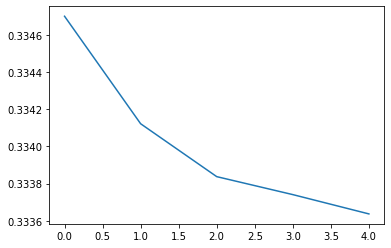

Epoch: 5 	Training Loss: 0.335176 	Validation Loss: 0.333637
Validation loss decreased (0.333741 --> 0.333637).  Saving model ...
epoch:  5
iteration:  200  loss: 22.454417057335377
iteration:  400  loss: 44.61093728989363
iteration:  600  loss: 67.08914443105459
iteration:  800  loss: 89.8741524592042


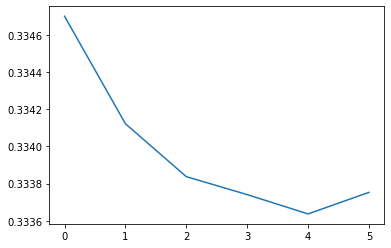

Epoch: 6 	Training Loss: 0.335176 	Validation Loss: 0.333753
epoch:  6
iteration:  200  loss: 20.87552068667719
iteration:  400  loss: 21.078641478197824
iteration:  600  loss: 21.186344314430244
iteration:  800  loss: 21.30516990934302


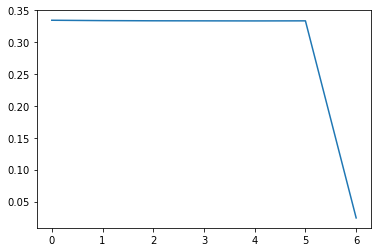

Epoch: 7 	Training Loss: 0.163191 	Validation Loss: 0.024411
Validation loss decreased (0.333637 --> 0.024411).  Saving model ...
epoch:  7
iteration:  200  loss: 0.08310967491524934
iteration:  400  loss: 0.1410946751798292
iteration:  600  loss: 0.2145604059037396
iteration:  800  loss: 0.27247736526214794


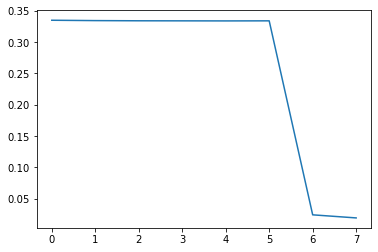

Epoch: 8 	Training Loss: 0.018455 	Validation Loss: 0.019497
Validation loss decreased (0.024411 --> 0.019497).  Saving model ...
epoch:  8
iteration:  200  loss: 0.05087519500921189
iteration:  400  loss: 0.09450520410973695
iteration:  600  loss: 0.13714441441425151
iteration:  800  loss: 0.1924470122294224


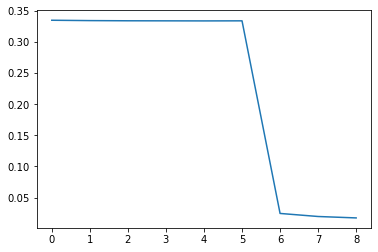

Epoch: 9 	Training Loss: 0.015510 	Validation Loss: 0.017220
Validation loss decreased (0.019497 --> 0.017220).  Saving model ...
epoch:  9
iteration:  200  loss: 0.03529369263105764
iteration:  400  loss: 0.08076338072078215
iteration:  600  loss: 0.12412240629691951
iteration:  800  loss: 0.16402139254660142


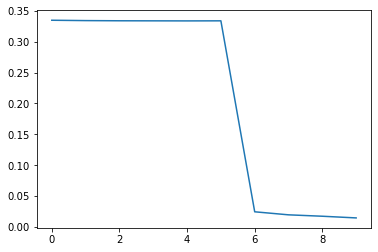

Epoch: 10 	Training Loss: 0.014319 	Validation Loss: 0.014499
Validation loss decreased (0.017220 --> 0.014499).  Saving model ...
epoch:  10
iteration:  200  loss: 0.029900643078690337
iteration:  400  loss: 0.06045918540439743
iteration:  600  loss: 0.10136564689855732
iteration:  800  loss: 0.1417248909638147


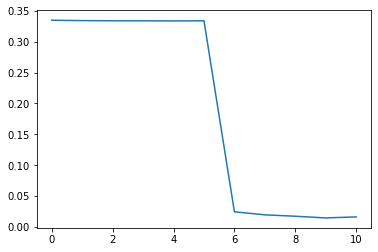

Epoch: 11 	Training Loss: 0.013310 	Validation Loss: 0.016160
epoch:  11
iteration:  200  loss: 0.03493213361616654
iteration:  400  loss: 0.0689547901001788
iteration:  600  loss: 0.1019488242263833
iteration:  800  loss: 0.12878636831646872


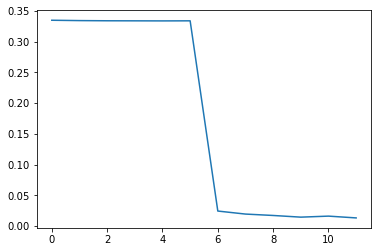

Epoch: 12 	Training Loss: 0.012688 	Validation Loss: 0.013244
Validation loss decreased (0.014499 --> 0.013244).  Saving model ...
epoch:  12
iteration:  200  loss: 0.03193301328610687
iteration:  400  loss: 0.06432864998350851
iteration:  600  loss: 0.09170125389937311
iteration:  800  loss: 0.1239590145778493


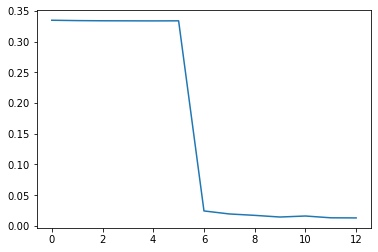

Epoch: 13 	Training Loss: 0.012448 	Validation Loss: 0.013056
Validation loss decreased (0.013244 --> 0.013056).  Saving model ...
epoch:  13
iteration:  200  loss: 0.02570980130803946
iteration:  400  loss: 0.05401087508562341
iteration:  600  loss: 0.08035643920948132
iteration:  800  loss: 0.11055715095471896


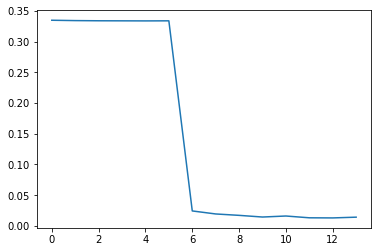

Epoch: 14 	Training Loss: 0.011756 	Validation Loss: 0.014273
epoch:  14
iteration:  200  loss: 0.025929184886081202
iteration:  400  loss: 0.05358891033301916
iteration:  600  loss: 0.0823861394319465
iteration:  800  loss: 0.11064995761307728


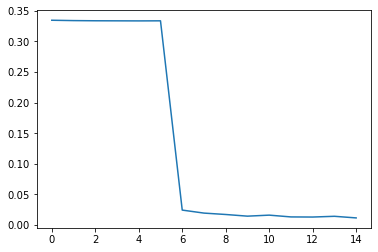

Epoch: 15 	Training Loss: 0.011761 	Validation Loss: 0.011622
Validation loss decreased (0.013056 --> 0.011622).  Saving model ...
epoch:  15
iteration:  200  loss: 0.025594569708118797
iteration:  400  loss: 0.052738498398866795
iteration:  600  loss: 0.07784406640394081
iteration:  800  loss: 0.11055015625106535


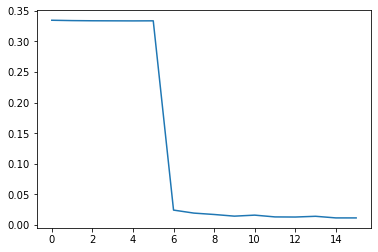

Epoch: 16 	Training Loss: 0.011755 	Validation Loss: 0.011612
Validation loss decreased (0.011622 --> 0.011612).  Saving model ...
epoch:  16
iteration:  200  loss: 0.025624760237406008
iteration:  400  loss: 0.05094125537107175
iteration:  600  loss: 0.0728833159446367
iteration:  800  loss: 0.09706336245290004


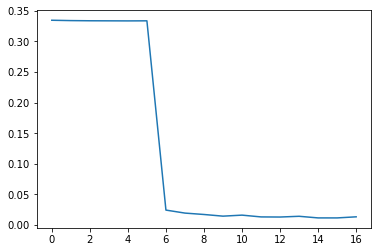

Epoch: 17 	Training Loss: 0.011015 	Validation Loss: 0.013399
epoch:  17
iteration:  200  loss: 0.022841246034204232
iteration:  400  loss: 0.042996209570901556
iteration:  600  loss: 0.06621193674936876
iteration:  800  loss: 0.08698316027312103


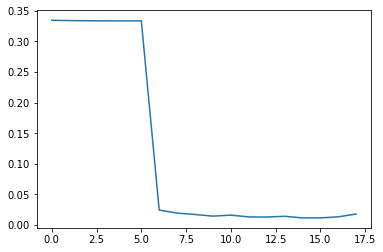

Epoch: 18 	Training Loss: 0.010427 	Validation Loss: 0.017946
epoch:  18
iteration:  200  loss: 0.02308793213114768
iteration:  400  loss: 0.04912013469856902
iteration:  600  loss: 0.07280793947529673
iteration:  800  loss: 0.10632078863454808


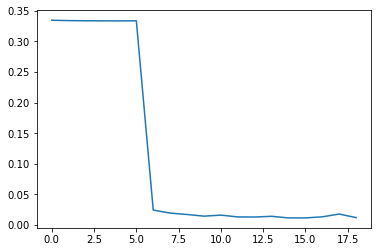

Epoch: 19 	Training Loss: 0.011528 	Validation Loss: 0.012101
epoch:  19
iteration:  200  loss: 0.0198151196955223
iteration:  400  loss: 0.04069511708803475
iteration:  600  loss: 0.06215635275157183
iteration:  800  loss: 0.08576339236924468


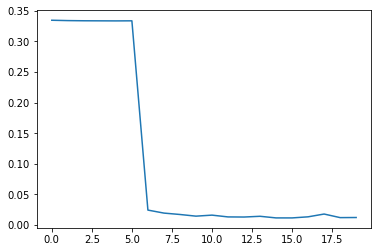

Epoch: 20 	Training Loss: 0.010354 	Validation Loss: 0.012270
epoch:  20
iteration:  200  loss: 0.018071626097025728
iteration:  400  loss: 0.04054184501433156
iteration:  600  loss: 0.07147311441144666
iteration:  800  loss: 0.09147858805204123


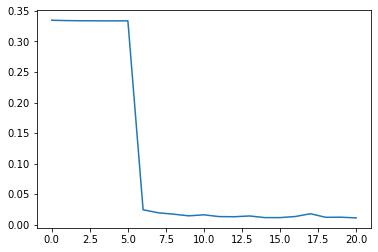

Epoch: 21 	Training Loss: 0.010693 	Validation Loss: 0.011100
Validation loss decreased (0.011612 --> 0.011100).  Saving model ...
epoch:  21
iteration:  200  loss: 0.022887485456521972
iteration:  400  loss: 0.04142092609527026
iteration:  600  loss: 0.06135502945517146
iteration:  800  loss: 0.08701181406013347


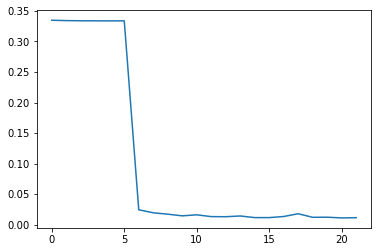

Epoch: 22 	Training Loss: 0.010429 	Validation Loss: 0.011493
epoch:  22
iteration:  200  loss: 0.02169943076751224
iteration:  400  loss: 0.04381621926449952
iteration:  600  loss: 0.06655560897479518
iteration:  800  loss: 0.09082266307405007


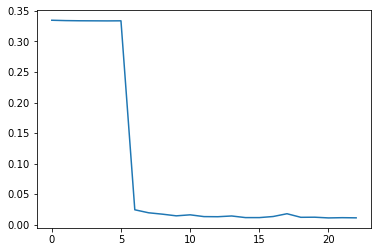

Epoch: 23 	Training Loss: 0.010655 	Validation Loss: 0.011227
epoch:  23
iteration:  200  loss: 0.018801534182330215
iteration:  400  loss: 0.044836867721187446
iteration:  600  loss: 0.06635543724632953
iteration:  800  loss: 0.08958070500875692


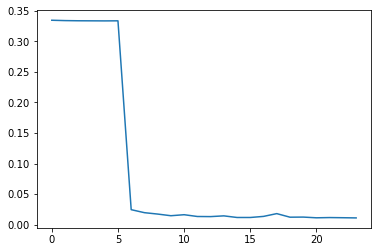

Epoch: 24 	Training Loss: 0.010582 	Validation Loss: 0.010912
Validation loss decreased (0.011100 --> 0.010912).  Saving model ...
epoch:  24
iteration:  200  loss: 0.018845760341264395
iteration:  400  loss: 0.0380172467544071
iteration:  600  loss: 0.05798211010187515
iteration:  800  loss: 0.07882834222709789


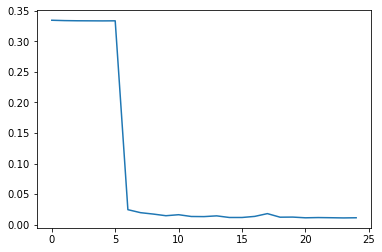

Epoch: 25 	Training Loss: 0.009927 	Validation Loss: 0.011163
epoch:  25
iteration:  200  loss: 0.018381803083002524
iteration:  400  loss: 0.03359627586564784
iteration:  600  loss: 0.054708059555650834
iteration:  800  loss: 0.07927406343924304


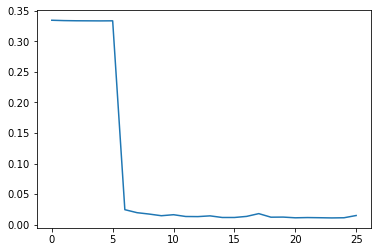

Epoch: 26 	Training Loss: 0.009955 	Validation Loss: 0.014845
epoch:  26
iteration:  200  loss: 0.019413087773500592
iteration:  400  loss: 0.0377089548208005
iteration:  600  loss: 0.058515777386446644
iteration:  800  loss: 0.07585476338658736


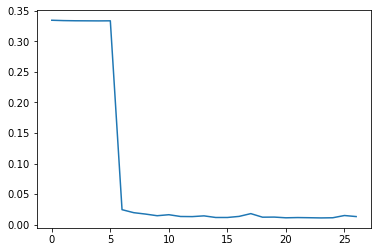

Epoch: 27 	Training Loss: 0.009737 	Validation Loss: 0.013118
epoch:  27
iteration:  200  loss: 0.019743644386835513
iteration:  400  loss: 0.03969174642861617
iteration:  600  loss: 0.05843776377014365
iteration:  800  loss: 0.07686410411542965


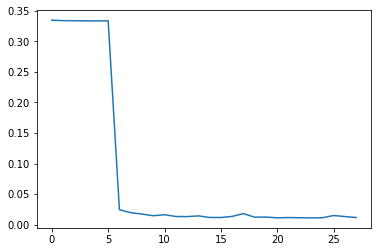

Epoch: 28 	Training Loss: 0.009802 	Validation Loss: 0.011550
epoch:  28
iteration:  200  loss: 0.023087248026513407
iteration:  400  loss: 0.04149655342234837
iteration:  600  loss: 0.056185008437296347
iteration:  800  loss: 0.07573995670736622


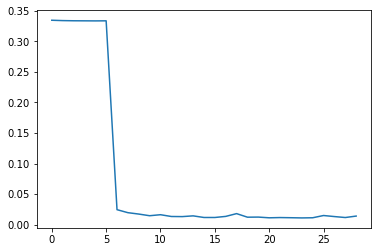

Epoch: 29 	Training Loss: 0.009730 	Validation Loss: 0.013928
epoch:  29
iteration:  200  loss: 0.016460183820527163
iteration:  400  loss: 0.03570832705599969
iteration:  600  loss: 0.05264754559266294
iteration:  800  loss: 0.07433615789886971


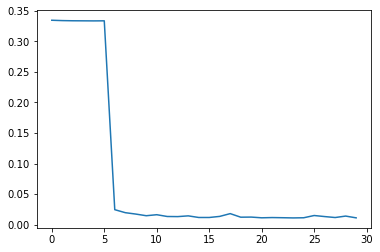

Epoch: 30 	Training Loss: 0.009640 	Validation Loss: 0.011014
epoch:  30
iteration:  200  loss: 0.01510618795919072
iteration:  400  loss: 0.030708406010489853
iteration:  600  loss: 0.045769877322527464
iteration:  800  loss: 0.06370451310681347


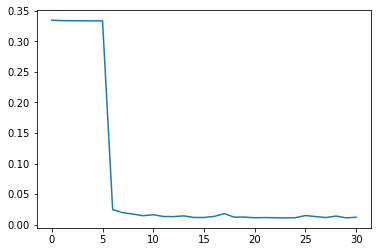

Epoch: 31 	Training Loss: 0.008924 	Validation Loss: 0.012003
epoch:  31
iteration:  200  loss: 0.01724778124344084
iteration:  400  loss: 0.03710302832041634
iteration:  600  loss: 0.05562550320769333
iteration:  800  loss: 0.0716931589156502


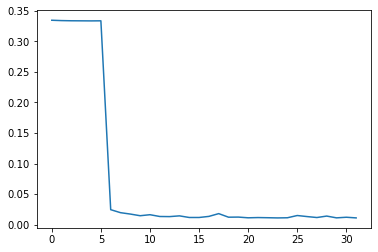

Epoch: 32 	Training Loss: 0.009467 	Validation Loss: 0.010938
epoch:  32
iteration:  200  loss: 0.015589110949122187
iteration:  400  loss: 0.034048842345555386
iteration:  600  loss: 0.05143374005297119
iteration:  800  loss: 0.07076094859326076


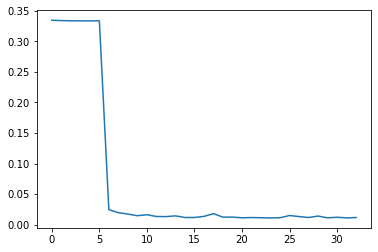

Epoch: 33 	Training Loss: 0.009405 	Validation Loss: 0.011508
epoch:  33
iteration:  200  loss: 0.023712712865744834
iteration:  400  loss: 0.0410363697660614
iteration:  600  loss: 0.057192070373957904
iteration:  800  loss: 0.07717085566332571


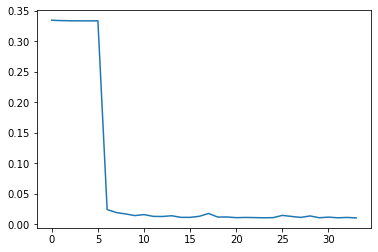

Epoch: 34 	Training Loss: 0.009822 	Validation Loss: 0.010708
Validation loss decreased (0.010912 --> 0.010708).  Saving model ...
epoch:  34
iteration:  200  loss: 0.016097588781121885
iteration:  400  loss: 0.031212810552460724
iteration:  600  loss: 0.05131820792894359
iteration:  800  loss: 0.06771822700966368


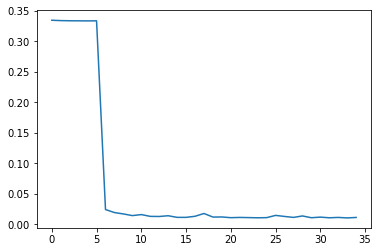

Epoch: 35 	Training Loss: 0.009200 	Validation Loss: 0.011458
epoch:  35
iteration:  200  loss: 0.01750305202108393
iteration:  400  loss: 0.03143678697301766
iteration:  600  loss: 0.04836720370508374
iteration:  800  loss: 0.0641119098775107


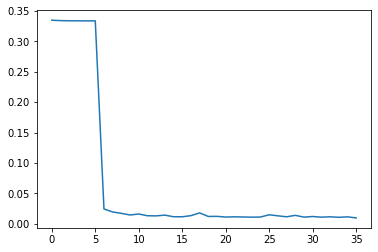

Epoch: 36 	Training Loss: 0.008952 	Validation Loss: 0.009699
Validation loss decreased (0.010708 --> 0.009699).  Saving model ...
epoch:  36
iteration:  200  loss: 0.016070808410859172
iteration:  400  loss: 0.03268847931167329
iteration:  600  loss: 0.048772253412607824
iteration:  800  loss: 0.06392845743403086


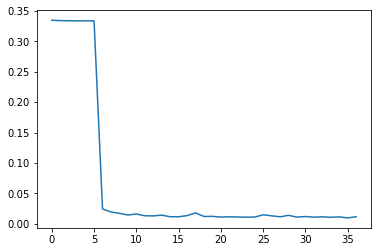

Epoch: 37 	Training Loss: 0.008939 	Validation Loss: 0.011613
epoch:  37
iteration:  200  loss: 0.018945007526326663
iteration:  400  loss: 0.03712763724047363
iteration:  600  loss: 0.05486824269587487
iteration:  800  loss: 0.07080901241374704


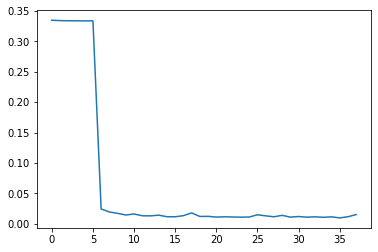

Epoch: 38 	Training Loss: 0.009408 	Validation Loss: 0.015222
epoch:  38
iteration:  200  loss: 0.014007513449314501
iteration:  400  loss: 0.030014976772690716
iteration:  600  loss: 0.04808285949866331
iteration:  800  loss: 0.06435289826049484


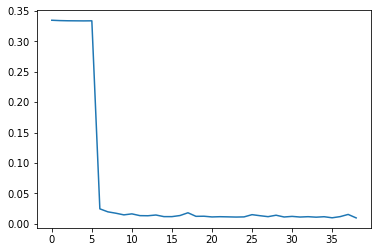

Epoch: 39 	Training Loss: 0.008969 	Validation Loss: 0.009492
Validation loss decreased (0.009699 --> 0.009492).  Saving model ...
epoch:  39
iteration:  200  loss: 0.018736067271220236
iteration:  400  loss: 0.036141177272384084
iteration:  600  loss: 0.05162382252433417
iteration:  800  loss: 0.06839615542753563


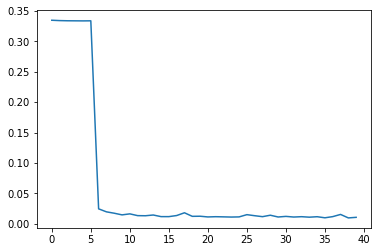

Epoch: 40 	Training Loss: 0.009246 	Validation Loss: 0.010456
epoch:  40
iteration:  200  loss: 0.013938012072230777
iteration:  400  loss: 0.030931722285458818
iteration:  600  loss: 0.04556424198517561
iteration:  800  loss: 0.05727535882124357


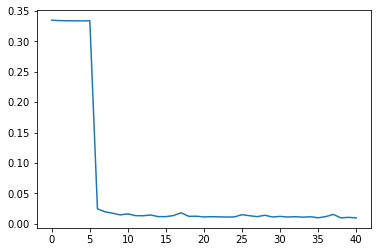

Epoch: 41 	Training Loss: 0.008461 	Validation Loss: 0.009530
epoch:  41
iteration:  200  loss: 0.014239988558756522
iteration:  400  loss: 0.02964765225328847
iteration:  600  loss: 0.04343478633381892
iteration:  800  loss: 0.05774191440332288


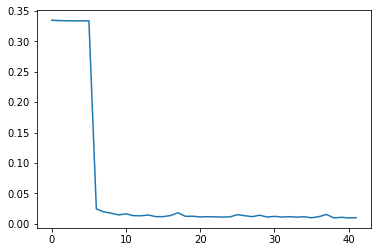

Epoch: 42 	Training Loss: 0.008496 	Validation Loss: 0.009813
epoch:  42
iteration:  200  loss: 0.01767623985483624
iteration:  400  loss: 0.03710552448728777
iteration:  600  loss: 0.05281625416614588
iteration:  800  loss: 0.06934366698737904


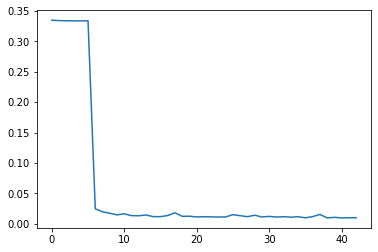

Epoch: 43 	Training Loss: 0.009310 	Validation Loss: 0.009792
epoch:  43
iteration:  200  loss: 0.013869134239484993
iteration:  400  loss: 0.030247469999721943
iteration:  600  loss: 0.048496656581846764
iteration:  800  loss: 0.062388551040157836


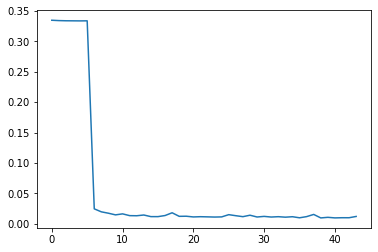

Epoch: 44 	Training Loss: 0.008831 	Validation Loss: 0.011905
epoch:  44
iteration:  200  loss: 0.015317818804078343
iteration:  400  loss: 0.03388045664019046
iteration:  600  loss: 0.05187391687809395
iteration:  800  loss: 0.0681347115034896


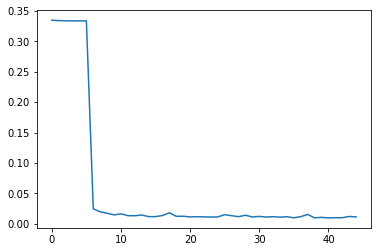

Epoch: 45 	Training Loss: 0.009229 	Validation Loss: 0.011097
epoch:  45
iteration:  200  loss: 0.014769242380225478
iteration:  400  loss: 0.028447462031749637
iteration:  600  loss: 0.043940830445649226
iteration:  800  loss: 0.057813789676743


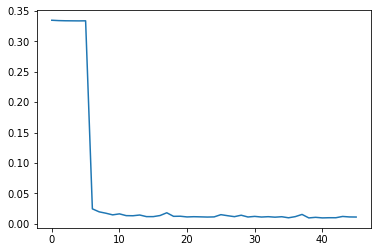

Epoch: 46 	Training Loss: 0.008501 	Validation Loss: 0.010945
epoch:  46
iteration:  200  loss: 0.014810086640864029
iteration:  400  loss: 0.028285365468718737
iteration:  600  loss: 0.04192234994752653
iteration:  800  loss: 0.056572834806502215


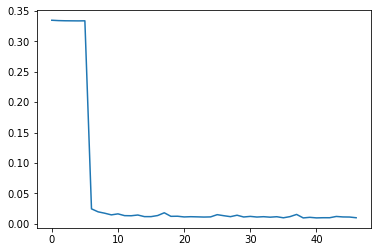

Epoch: 47 	Training Loss: 0.008409 	Validation Loss: 0.009771
epoch:  47
iteration:  200  loss: 0.01221140286179434
iteration:  400  loss: 0.024900764751805582
iteration:  600  loss: 0.04188393678737157
iteration:  800  loss: 0.05982120463249885


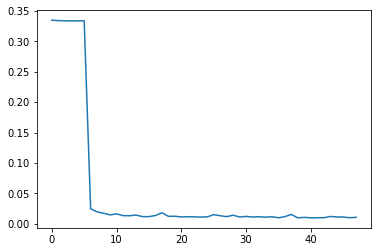

Epoch: 48 	Training Loss: 0.008647 	Validation Loss: 0.010434
epoch:  48
iteration:  200  loss: 0.014302116858289082
iteration:  400  loss: 0.02547962783000912
iteration:  600  loss: 0.041066743624696755
iteration:  800  loss: 0.05673283565852216


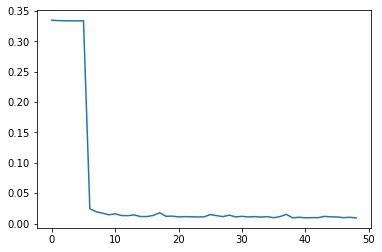

Epoch: 49 	Training Loss: 0.008421 	Validation Loss: 0.009373
Validation loss decreased (0.009492 --> 0.009373).  Saving model ...
epoch:  49
iteration:  200  loss: 0.013138001636548324
iteration:  400  loss: 0.026324100466922573
iteration:  600  loss: 0.03898509831435604
iteration:  800  loss: 0.04991388401288077


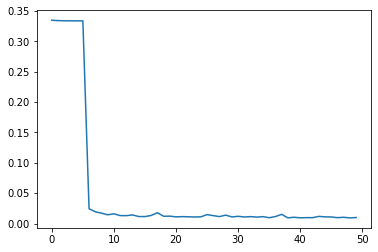

Epoch: 50 	Training Loss: 0.007899 	Validation Loss: 0.010004
epoch:  50
iteration:  200  loss: 0.013492366202740413
iteration:  400  loss: 0.024864636652978334
iteration:  600  loss: 0.04444351753193132
iteration:  800  loss: 0.06224804094392766


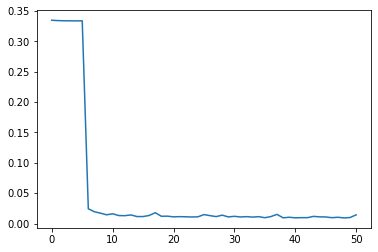

Epoch: 51 	Training Loss: 0.008821 	Validation Loss: 0.014438
epoch:  51
iteration:  200  loss: 0.01138582905741714
iteration:  400  loss: 0.023571426176431487
iteration:  600  loss: 0.03509820327030866
iteration:  800  loss: 0.05144934867325901


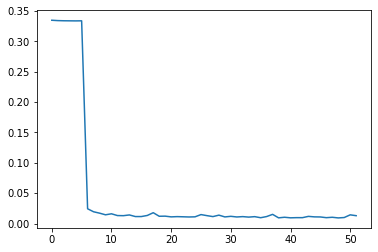

Epoch: 52 	Training Loss: 0.008019 	Validation Loss: 0.013048
epoch:  52
iteration:  200  loss: 0.014851708119294926
iteration:  400  loss: 0.032240897670703816
iteration:  600  loss: 0.049165574564881354
iteration:  800  loss: 0.05980144542229482


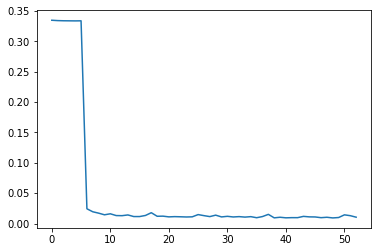

Epoch: 53 	Training Loss: 0.008646 	Validation Loss: 0.010564
epoch:  53
iteration:  200  loss: 0.013361756098902333
iteration:  400  loss: 0.026120649536096607
iteration:  600  loss: 0.03939617636615367
iteration:  800  loss: 0.052801690753085495


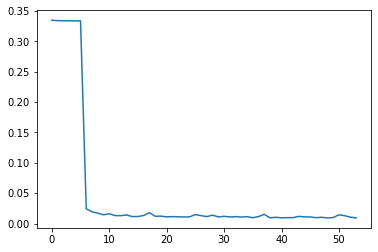

Epoch: 54 	Training Loss: 0.008124 	Validation Loss: 0.009378
epoch:  54
iteration:  200  loss: 0.01901059327110488
iteration:  400  loss: 0.03150631515052282
iteration:  600  loss: 0.04518314648692012
iteration:  800  loss: 0.05684286667371907


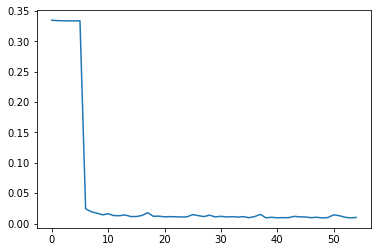

Epoch: 55 	Training Loss: 0.008429 	Validation Loss: 0.010165
epoch:  55
iteration:  200  loss: 0.013554626645714052
iteration:  400  loss: 0.027532770999755485
iteration:  600  loss: 0.04242429314888341
iteration:  800  loss: 0.05755946874455731


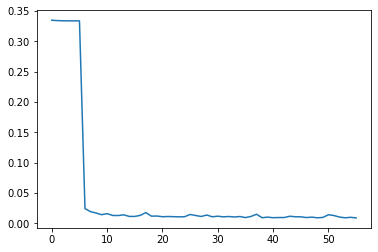

Epoch: 56 	Training Loss: 0.008482 	Validation Loss: 0.009168
Validation loss decreased (0.009373 --> 0.009168).  Saving model ...
epoch:  56
iteration:  200  loss: 0.009893960002500535
iteration:  400  loss: 0.023454177992334735
iteration:  600  loss: 0.036235000156011665
iteration:  800  loss: 0.052390870729368544


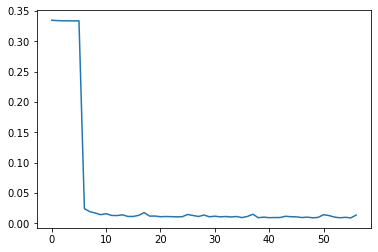

Epoch: 57 	Training Loss: 0.008093 	Validation Loss: 0.013862
epoch:  57
iteration:  200  loss: 0.012758075386727796
iteration:  400  loss: 0.02442350184969655
iteration:  600  loss: 0.038277347382063454
iteration:  800  loss: 0.049283384311138434


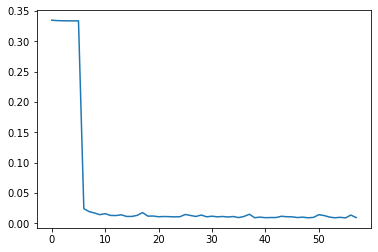

Epoch: 58 	Training Loss: 0.007849 	Validation Loss: 0.009697
epoch:  58
iteration:  200  loss: 0.015690509850628587
iteration:  400  loss: 0.03351906342231814
iteration:  600  loss: 0.04414776869180059
iteration:  800  loss: 0.05705477345122745


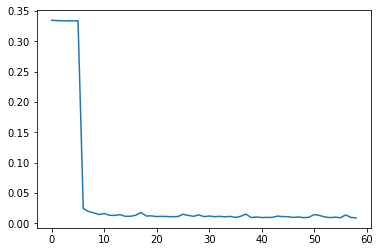

Epoch: 59 	Training Loss: 0.008445 	Validation Loss: 0.008925
Validation loss decreased (0.009168 --> 0.008925).  Saving model ...
epoch:  59
iteration:  200  loss: 0.00913377367760404
iteration:  400  loss: 0.022861952256789664
iteration:  600  loss: 0.036161701499850096
iteration:  800  loss: 0.05086156610946091


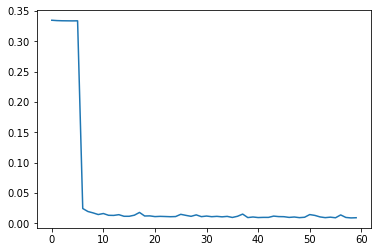

Epoch: 60 	Training Loss: 0.007974 	Validation Loss: 0.009225
epoch:  60
iteration:  200  loss: 0.013384992531200623
iteration:  400  loss: 0.025993401552113937
iteration:  600  loss: 0.04139883986732684
iteration:  800  loss: 0.051182360676477856


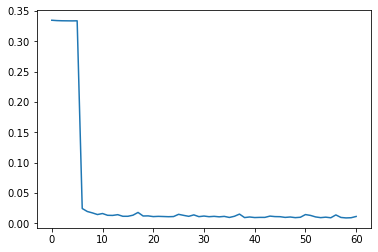

Epoch: 61 	Training Loss: 0.007999 	Validation Loss: 0.011314
epoch:  61
iteration:  200  loss: 0.012051105775753967
iteration:  400  loss: 0.02587130452116071
iteration:  600  loss: 0.04039618385809263
iteration:  800  loss: 0.05279839099125638


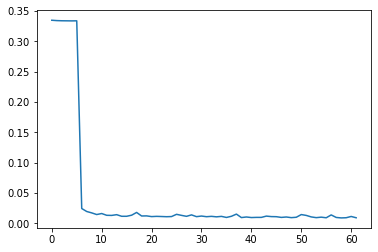

Epoch: 62 	Training Loss: 0.008124 	Validation Loss: 0.009170
epoch:  62
iteration:  200  loss: 0.011752041182262474
iteration:  400  loss: 0.029157730393080783
iteration:  600  loss: 0.04178986994702427
iteration:  800  loss: 0.054181771210778606


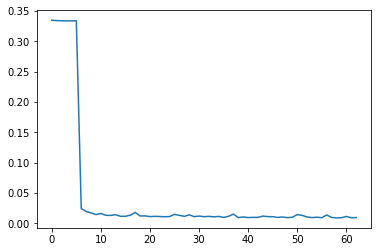

Epoch: 63 	Training Loss: 0.008230 	Validation Loss: 0.009508
epoch:  63
iteration:  200  loss: 0.010800298718777412
iteration:  400  loss: 0.02450503828208639
iteration:  600  loss: 0.034220591878693085
iteration:  800  loss: 0.045953258348617965


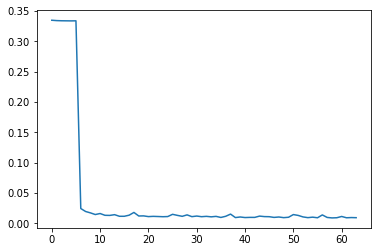

Epoch: 64 	Training Loss: 0.007579 	Validation Loss: 0.009298
epoch:  64
iteration:  200  loss: 0.012106353414537807
iteration:  400  loss: 0.023826628503229585
iteration:  600  loss: 0.03495800208042965
iteration:  800  loss: 0.04845583993096625


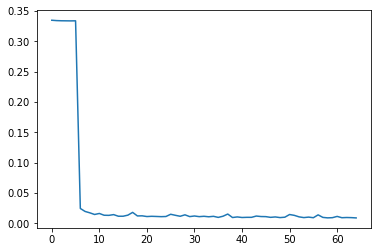

Epoch: 65 	Training Loss: 0.007783 	Validation Loss: 0.008834
Validation loss decreased (0.008925 --> 0.008834).  Saving model ...
epoch:  65
iteration:  200  loss: 0.011142005814690492
iteration:  400  loss: 0.023769696782437677
iteration:  600  loss: 0.037220811649149255
iteration:  800  loss: 0.05154307925613466


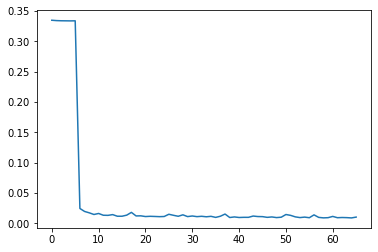

Epoch: 66 	Training Loss: 0.008027 	Validation Loss: 0.010193
epoch:  66
iteration:  200  loss: 0.011187120395902639
iteration:  400  loss: 0.02257361063936969
iteration:  600  loss: 0.0345405684073512
iteration:  800  loss: 0.04549218230351926


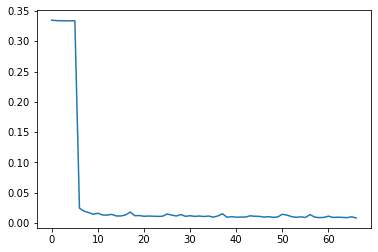

Epoch: 67 	Training Loss: 0.007541 	Validation Loss: 0.008396
Validation loss decreased (0.008834 --> 0.008396).  Saving model ...
epoch:  67
iteration:  200  loss: 0.010624341989228014
iteration:  400  loss: 0.026299718889390533
iteration:  600  loss: 0.04092277179472603
iteration:  800  loss: 0.05214160736488793


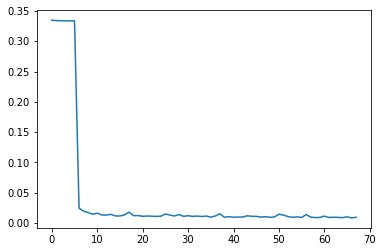

Epoch: 68 	Training Loss: 0.008073 	Validation Loss: 0.009443
epoch:  68
iteration:  200  loss: 0.011079461612553132
iteration:  400  loss: 0.02127137505101473
iteration:  600  loss: 0.03263276025165851
iteration:  800  loss: 0.04603448311615921


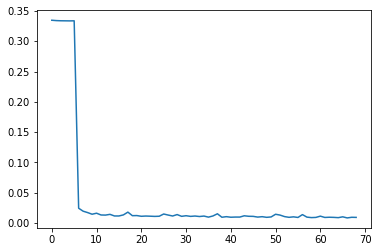

Epoch: 69 	Training Loss: 0.007586 	Validation Loss: 0.009256
epoch:  69
iteration:  200  loss: 0.01281934510825522
iteration:  400  loss: 0.02421298942908834
iteration:  600  loss: 0.0345022988741448
iteration:  800  loss: 0.045530981057595454


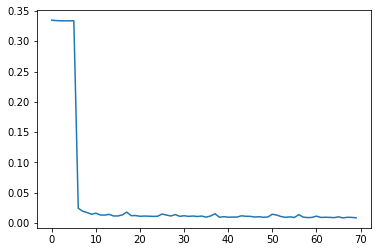

Epoch: 70 	Training Loss: 0.007544 	Validation Loss: 0.008614
epoch:  70
iteration:  200  loss: 0.01160896060378036
iteration:  400  loss: 0.02281732916208057
iteration:  600  loss: 0.03527529029247489
iteration:  800  loss: 0.04540207098921201


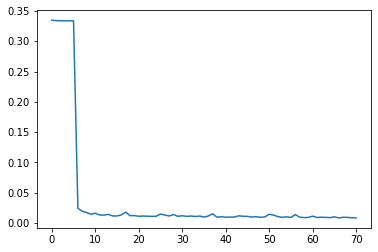

Epoch: 71 	Training Loss: 0.007533 	Validation Loss: 0.008440
epoch:  71
iteration:  200  loss: 0.014779373872102042
iteration:  400  loss: 0.025811985278664906
iteration:  600  loss: 0.03855319361503007
iteration:  800  loss: 0.05030076783714321


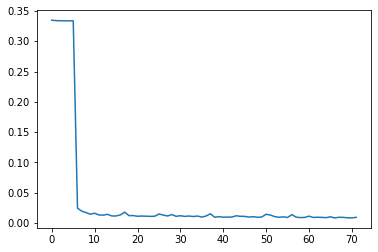

Epoch: 72 	Training Loss: 0.007929 	Validation Loss: 0.009361
epoch:  72
iteration:  200  loss: 0.012149330690590432
iteration:  400  loss: 0.02305392272410245
iteration:  600  loss: 0.03385911338364167
iteration:  800  loss: 0.04569739335693157


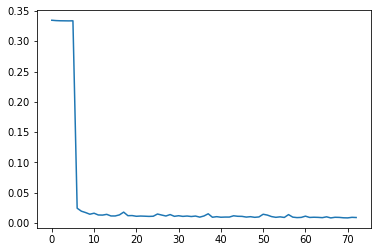

Epoch: 73 	Training Loss: 0.007558 	Validation Loss: 0.009061
epoch:  73
iteration:  200  loss: 0.010399127933396812
iteration:  400  loss: 0.024973042435021853
iteration:  600  loss: 0.03624660288960513
iteration:  800  loss: 0.046367096486847004


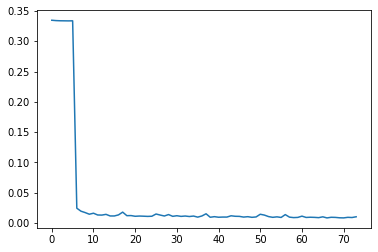

Epoch: 74 	Training Loss: 0.007613 	Validation Loss: 0.010275
epoch:  74
iteration:  200  loss: 0.010771719941772062
iteration:  400  loss: 0.021945334426504814
iteration:  600  loss: 0.03327360364676224
iteration:  800  loss: 0.04426795403230699


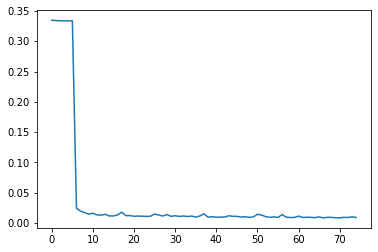

Epoch: 75 	Training Loss: 0.007439 	Validation Loss: 0.009083
epoch:  75
iteration:  200  loss: 0.01280689296163473
iteration:  400  loss: 0.023094147581787183
iteration:  600  loss: 0.03724879264859737
iteration:  800  loss: 0.04932320026762227


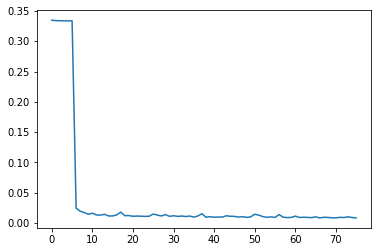

Epoch: 76 	Training Loss: 0.007852 	Validation Loss: 0.008454
epoch:  76
iteration:  200  loss: 0.011380628438701024
iteration:  400  loss: 0.02428801124619895
iteration:  600  loss: 0.035336067635171275
iteration:  800  loss: 0.047754208112792185


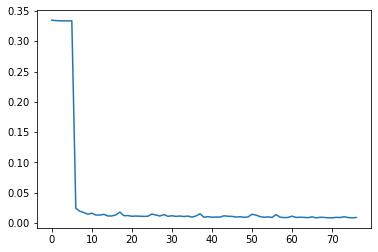

Epoch: 77 	Training Loss: 0.007726 	Validation Loss: 0.009061
epoch:  77
iteration:  200  loss: 0.009903429770702132
iteration:  400  loss: 0.020140937051792207
iteration:  600  loss: 0.03178857363491261
iteration:  800  loss: 0.044599983944181076


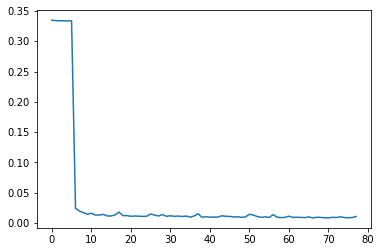

Epoch: 78 	Training Loss: 0.007467 	Validation Loss: 0.010671
epoch:  78
iteration:  200  loss: 0.011704357081043781
iteration:  400  loss: 0.02230705684428358
iteration:  600  loss: 0.03141143293009918
iteration:  800  loss: 0.04246677447599723


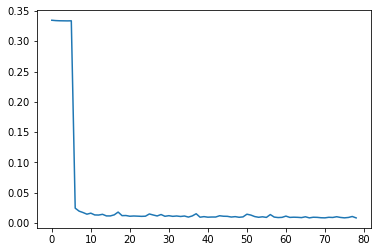

Epoch: 79 	Training Loss: 0.007286 	Validation Loss: 0.008324
Validation loss decreased (0.008396 --> 0.008324).  Saving model ...
epoch:  79
iteration:  200  loss: 0.01175155241730863
iteration:  400  loss: 0.02179625432120247
iteration:  600  loss: 0.03459361710565645
iteration:  800  loss: 0.045178523179401964


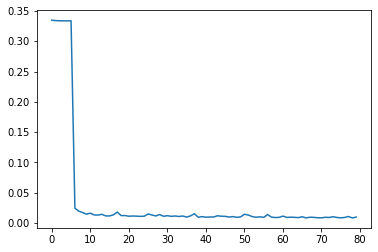

Epoch: 80 	Training Loss: 0.007515 	Validation Loss: 0.009691
epoch:  80
iteration:  200  loss: 0.00981175114634425
iteration:  400  loss: 0.02323303011209532
iteration:  600  loss: 0.0343217301417269
iteration:  800  loss: 0.04417107676997034


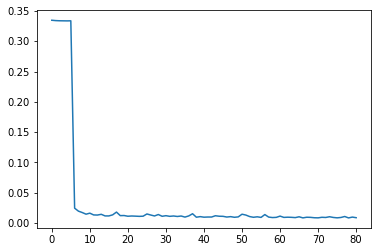

Epoch: 81 	Training Loss: 0.007431 	Validation Loss: 0.008682
epoch:  81
iteration:  200  loss: 0.01145703257589048
iteration:  400  loss: 0.02306285582108103
iteration:  600  loss: 0.033880707697221624
iteration:  800  loss: 0.046190026940962525


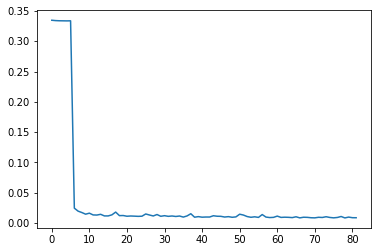

Epoch: 82 	Training Loss: 0.007599 	Validation Loss: 0.008622
epoch:  82
iteration:  200  loss: 0.011206538385522435
iteration:  400  loss: 0.02392182181336011
iteration:  600  loss: 0.03378100727547917
iteration:  800  loss: 0.043676649368194376


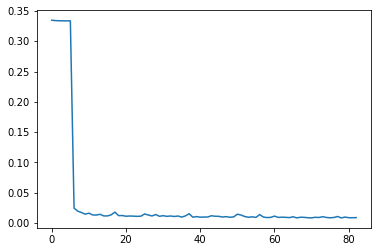

Epoch: 83 	Training Loss: 0.007389 	Validation Loss: 0.008852
epoch:  83
iteration:  200  loss: 0.011707764455536562
iteration:  400  loss: 0.02085702147758184
iteration:  600  loss: 0.032236831514524056
iteration:  800  loss: 0.043190943370404966


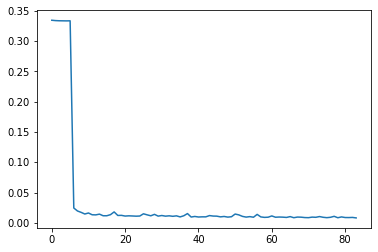

Epoch: 84 	Training Loss: 0.007348 	Validation Loss: 0.008036
Validation loss decreased (0.008324 --> 0.008036).  Saving model ...
epoch:  84
iteration:  200  loss: 0.011445534200447582
iteration:  400  loss: 0.023277175350472135
iteration:  600  loss: 0.03405190891191978
iteration:  800  loss: 0.043160122166568726


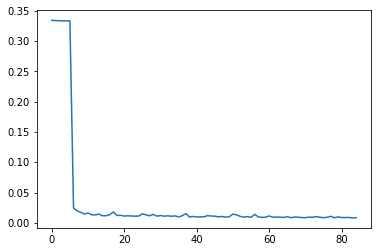

Epoch: 85 	Training Loss: 0.007345 	Validation Loss: 0.008432
epoch:  85
iteration:  200  loss: 0.0098295228904135
iteration:  400  loss: 0.01983770404058305
iteration:  600  loss: 0.029436512515871982
iteration:  800  loss: 0.03918139144639099


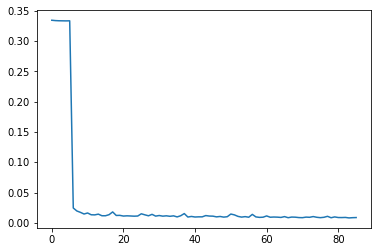

Epoch: 86 	Training Loss: 0.006998 	Validation Loss: 0.008628
epoch:  86
iteration:  200  loss: 0.008704904811111192
iteration:  400  loss: 0.018797741357502673
iteration:  600  loss: 0.02864937384742916
iteration:  800  loss: 0.04201557102510378


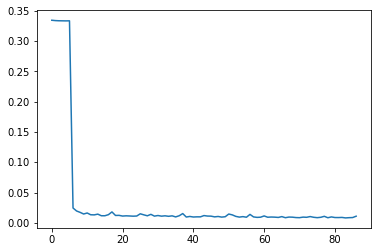

Epoch: 87 	Training Loss: 0.007247 	Validation Loss: 0.010862
epoch:  87
iteration:  200  loss: 0.010271155047348657
iteration:  400  loss: 0.018958964730700245
iteration:  600  loss: 0.02816474943489311
iteration:  800  loss: 0.04129000971994401


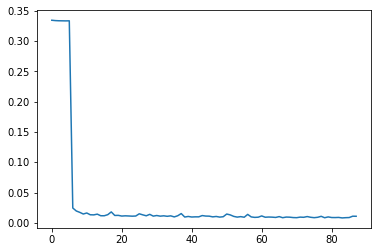

Epoch: 88 	Training Loss: 0.007184 	Validation Loss: 0.010760
epoch:  88
iteration:  200  loss: 0.00987502853274691
iteration:  400  loss: 0.019771317177116998
iteration:  600  loss: 0.0319316682773092
iteration:  800  loss: 0.046049744125127745


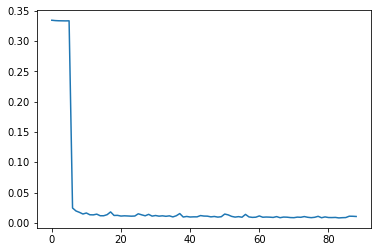

Epoch: 89 	Training Loss: 0.007587 	Validation Loss: 0.010415
epoch:  89
iteration:  200  loss: 0.008710789579254197
iteration:  400  loss: 0.017398558459035485
iteration:  600  loss: 0.029222698508419853
iteration:  800  loss: 0.03864785827818196


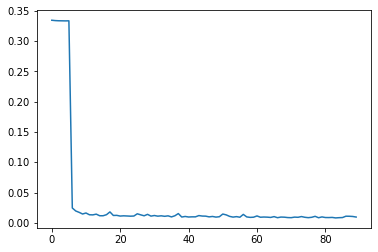

Epoch: 90 	Training Loss: 0.006951 	Validation Loss: 0.009459
epoch:  90
iteration:  200  loss: 0.010432802767923022
iteration:  400  loss: 0.020292907115731396
iteration:  600  loss: 0.030784683587285144
iteration:  800  loss: 0.039124102843175024


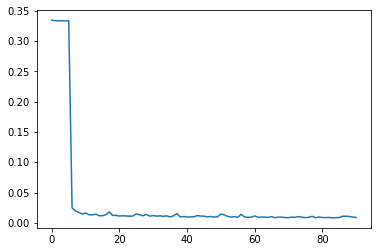

Epoch: 91 	Training Loss: 0.006993 	Validation Loss: 0.008720
epoch:  91
iteration:  200  loss: 0.00882337341568018
iteration:  400  loss: 0.02139655027781373
iteration:  600  loss: 0.03044734209811395
iteration:  800  loss: 0.04008925870039093


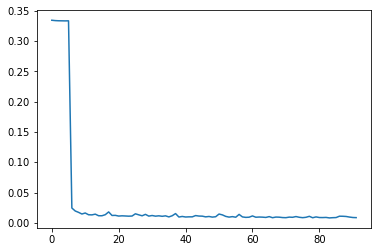

Epoch: 92 	Training Loss: 0.007079 	Validation Loss: 0.008500
epoch:  92
iteration:  200  loss: 0.01027835115542075
iteration:  400  loss: 0.019137430384716936
iteration:  600  loss: 0.027917851595020693
iteration:  800  loss: 0.03737537921642797


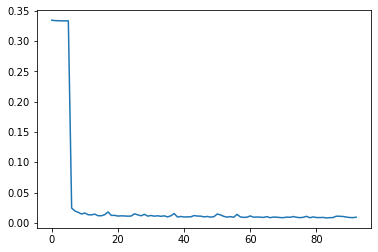

Epoch: 93 	Training Loss: 0.006835 	Validation Loss: 0.009185
epoch:  93
iteration:  200  loss: 0.011541391115542865
iteration:  400  loss: 0.021850747444432272
iteration:  600  loss: 0.034648900329102617
iteration:  800  loss: 0.044211843889570446


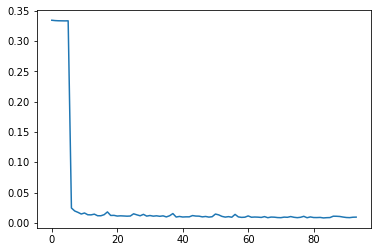

Epoch: 94 	Training Loss: 0.007434 	Validation Loss: 0.009354
epoch:  94
iteration:  200  loss: 0.012983774069198262
iteration:  400  loss: 0.024336834930409168
iteration:  600  loss: 0.03231088333450316
iteration:  800  loss: 0.041148280016841454


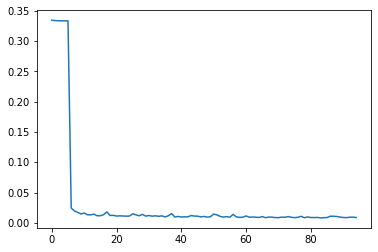

Epoch: 95 	Training Loss: 0.007172 	Validation Loss: 0.008760
epoch:  95
iteration:  200  loss: 0.00809659863170964
iteration:  400  loss: 0.016721871120125797
iteration:  600  loss: 0.02912398965054308
iteration:  800  loss: 0.03831802584659272


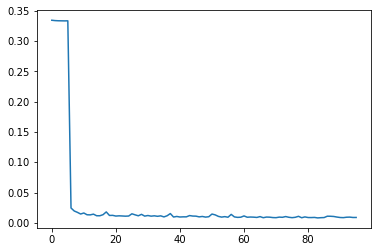

Epoch: 96 	Training Loss: 0.006921 	Validation Loss: 0.008781
epoch:  96
iteration:  200  loss: 0.009336602770758873
iteration:  400  loss: 0.02279548816056831
iteration:  600  loss: 0.031684991670204
iteration:  800  loss: 0.04309789797559915


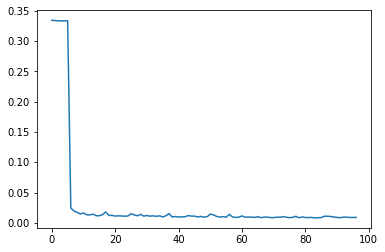

Epoch: 97 	Training Loss: 0.007340 	Validation Loss: 0.008888
epoch:  97
iteration:  200  loss: 0.011747926902216932
iteration:  400  loss: 0.020764268406310293
iteration:  600  loss: 0.030440493294690896
iteration:  800  loss: 0.039490414360898285


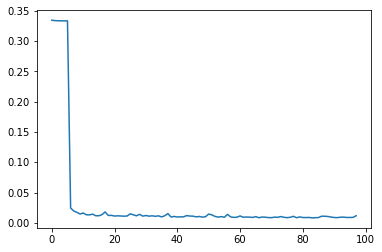

Epoch: 98 	Training Loss: 0.007026 	Validation Loss: 0.011642
epoch:  98
iteration:  200  loss: 0.01173198635888184
iteration:  400  loss: 0.022536966351708543
iteration:  600  loss: 0.03289672057530879
iteration:  800  loss: 0.041424040990932554


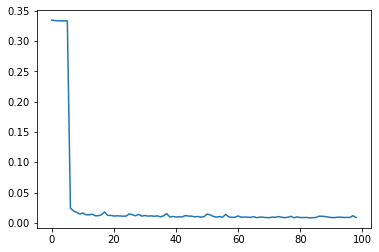

Epoch: 99 	Training Loss: 0.007196 	Validation Loss: 0.008647
epoch:  99
iteration:  200  loss: 0.009559003806884903
iteration:  400  loss: 0.018233353428968258
iteration:  600  loss: 0.028175140997404924
iteration:  800  loss: 0.03861176658813292


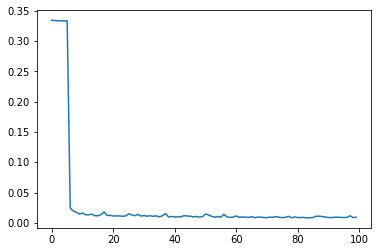

Epoch: 100 	Training Loss: 0.006947 	Validation Loss: 0.009096


In [16]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = AdvancedCNN()
model = model.to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
print('----train-----')
train_loss, val_loss = train(train_loader, valid_loader, model, criterion, optimizer, n_epochs=100, saved_model = 'cnn.pt')